### Importing Relevant Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns

sns.set_theme(context="notebook", style="white")

### Loading and Transforming the Data

In [2]:
raw_csv_data = pd.read_csv("Index2018.csv")
df_comp = raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst=True)
df_comp.set_index("date", inplace=True)
df_comp = df_comp.asfreq("b")  # Set frequency to business days
df_comp = df_comp.ffill()



### Removing Surplus Data

In [3]:
df_comp["market_value"] = df_comp.spx

In [4]:
del df_comp["spx"]
del df_comp["dax"]
del df_comp["ftse"]
del df_comp["nikkei"]
size = int(len(df_comp) * 0.8)
df, df_test = df_comp.iloc[:size].copy(), df_comp.iloc[size:].copy()

### White Noise

 - Generate random normally distributed data.
 - For this to be comparable to the spx data, its mean and standard deviation need to be set to that of the actual set.

In [5]:
df.loc[:, "white_noise"] = np.random.normal(
    loc=df["market_value"].mean(), scale=df["market_value"].std(), size=len(df)
)
df.describe()

,market_value,white_noise
count,5021.000000,5021.000000
mean,1091.651926,1092.100997
std,292.559287,286.830414
min,438.920000,103.531272
25%,914.620000,900.258592
50%,1144.650000,1093.365494
75%,1316.280729,1285.217949
max,1570.252238,2208.395219


In [6]:
df.head()

,market_value,white_noise
date,,
1994-01-07,469.90,1071.695062
1994-01-10,475.27,805.440184
1994-01-11,474.13,1048.885095
1994-01-12,474.17,949.827708
1994-01-13,472.47,1330.799426


- Because each value is generated individually, the mean and standard deviation of the generated data are similar but not necessarily the same as spx.

#### Plot the data

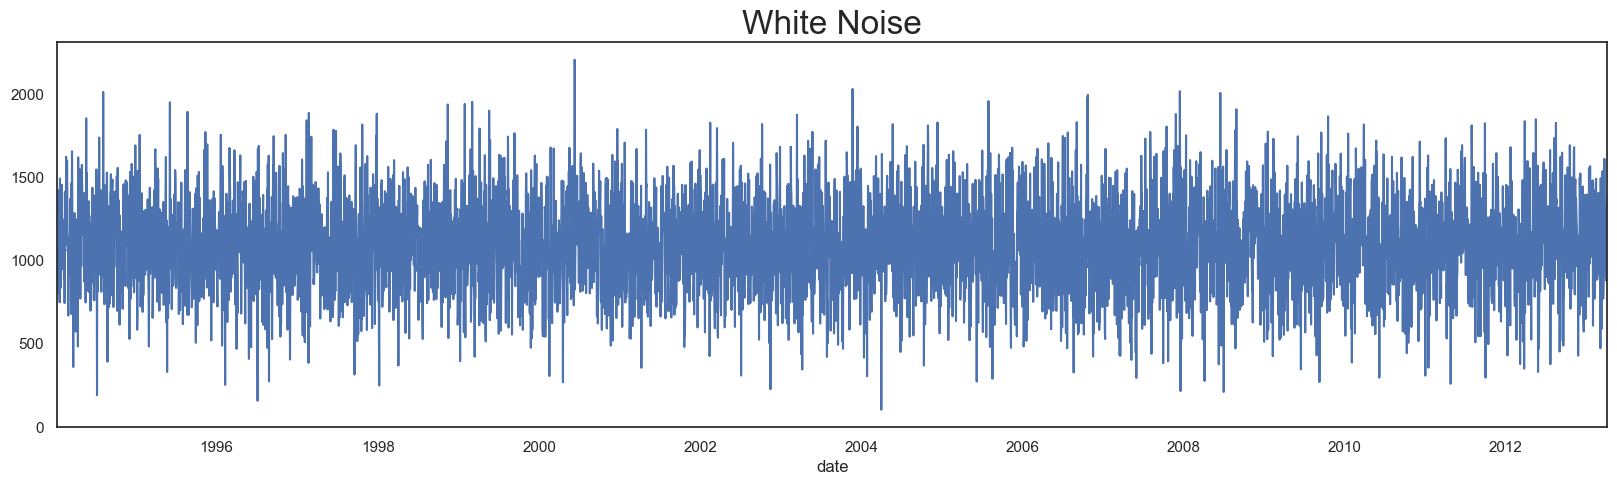

In [7]:
plt.figure(figsize=(20, 5))
df["white_noise"].plot(label="White Noise")
plt.title("White Noise", size=24)
y_limits = plt.ylim()  # Needs to be called before plt.show()
plt.show()

For the graphs to be comparable, set the y-axis limits of the S&P500 graph to be the same as the white noise graph.

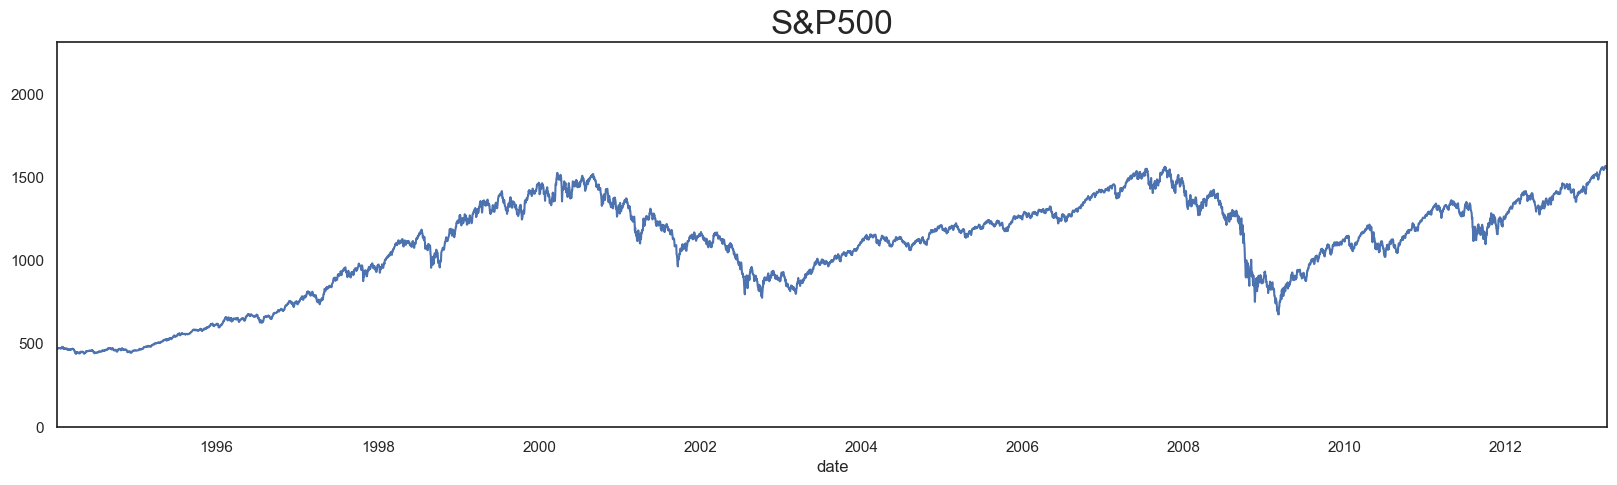

In [ ]:
plt.figure(figsize=(20, 5))
df["market_value"].plot(label="S&P500")
plt.title("S&P500", size=24)
plt.ylim(y_limits)  # Use the same y limits as the white noise graph
plt.show()

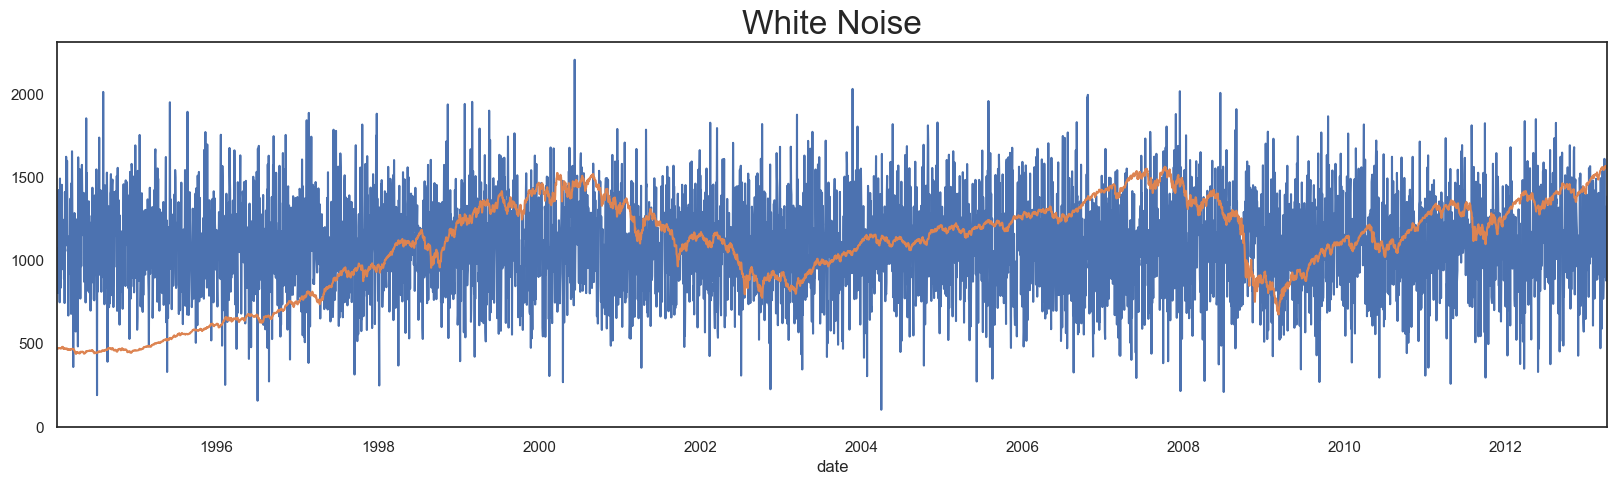

In [ ]:
plt.figure(figsize=(20, 5))
df["white_noise"].plot(label="White Noise")
df["market_value"].plot(label="S&P00")
plt.title("White Noise", size=24)
plt.show()

### Random Walk

- For this workbook, load the existing random walk dataset and add it to the dataframe.
- The dataset represents prices generated using a random walk.

In [ ]:
random_walk = pd.read_csv("RandWalk.csv")
random_walk["date"] = pd.to_datetime(random_walk["date"], dayfirst=True)
random_walk = random_walk.set_index("date")
random_walk = random_walk.asfreq("b")
random_walk

,price
date,
1994-01-07,1122.139662
1994-01-10,1080.347860
1994-01-11,1082.095245
1994-01-12,1083.639265
1994-01-13,1067.146255
...,...
2013-04-01,2263.675474
2013-04-02,2225.000870
2013-04-03,2190.787688


In [11]:
random_walk.describe()

,price
count,5021.000000
mean,1269.944293
std,444.216793
min,585.483034
25%,931.550429
50%,1156.363045
75%,1488.362029
max,2715.508720


Add the random walk data to `df` as a new column.

In [ ]:
df["random_walk"] = random_walk["price"]
df.head()

,market_value,white_noise,random_walk
date,,,
1994-01-07,469.90,1071.695062,1122.139662
1994-01-10,475.27,805.440184,1080.347860
1994-01-11,474.13,1048.885095,1082.095245
1994-01-12,474.17,949.827708,1083.639265
1994-01-13,472.47,1330.799426,1067.146255


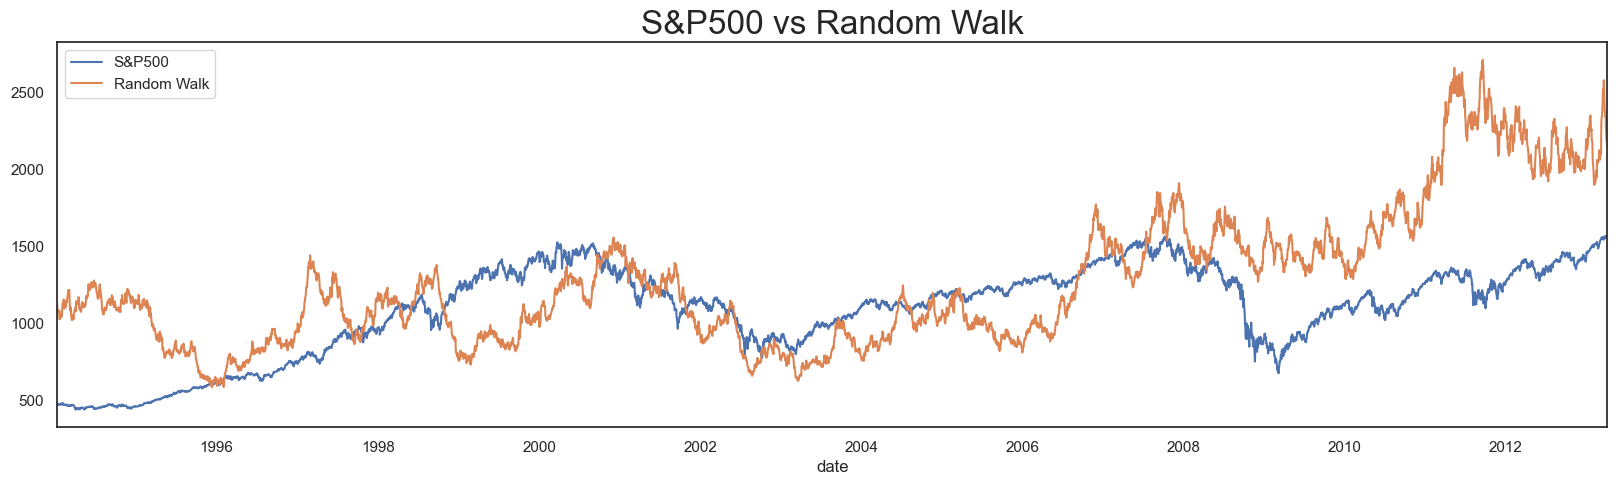

In [ ]:
plt.figure(figsize=(20, 5))
df["market_value"].plot(label="S&P500")
df["random_walk"].plot(label="Random Walk")
plt.title("S&P500 vs Random Walk", size=24)
plt.legend()
plt.show()

Both show cyclical changes and have variations over time.

### Stationarity

#### S&P500

In [ ]:
def print_dickey_fuller(result):
    print(f"t-statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"lags used in regression: {result[2]}")
    print(f"No. of observations used in the analysis: {result[3]}")
    print(f"Augmented Dickey-Fuller critical values: {result[4]}")

In [15]:
result = sts.adfuller(df["market_value"])
result

(np.float64(-1.7369847452352465),
 np.float64(0.4121645696770607),
 18,
 5002,
 {'1%': np.float64(-3.431658008603046),
  '5%': np.float64(-2.862117998412982),
  '10%': np.float64(-2.567077669247375)},
 np.float64(39904.880607487445))

In [16]:
print_dickey_fuller(result)

t-statistic: -1.7369847452352465
p-value: 0.4121645696770607
lags used in regression: 18
No. of observations used in the analysis: 5002
Augmented Dickey-Fuller critical values: {'1%': np.float64(-3.431658008603046), '5%': np.float64(-2.862117998412982), '10%': np.float64(-2.567077669247375)}


- The t-statistic (-1.73698) is greater than any of the critical values, which means that the null hypothesis that the data is non-stationary cannot be rejected.
- The p-value (0.41) indicates a 41% chance of not rejecting the null hypothesis, which means that it cannot be confirmed that the data is stationary.
- Therefore there is no evidence of stationarity.
- The number of lags used in the regression when determining the t-statistic indicates autocorrelation going back 18 periods. This needs to be taken into account when picking the appropriate model.

#### White Noise

In [17]:
result = sts.adfuller(df["white_noise"])
result

(np.float64(-70.78517248985418),
 0.0,
 0,
 5020,
 {'1%': np.float64(-3.431653316130827),
  '5%': np.float64(-2.8621159253018247),
  '10%': np.float64(-2.5670765656497516)},
 np.float64(70622.48148795201))

In [18]:
print_dickey_fuller(result)

t-statistic: -70.78517248985418
p-value: 0.0
lags used in regression: 0
No. of observations used in the analysis: 5020
Augmented Dickey-Fuller critical values: {'1%': np.float64(-3.431653316130827), '5%': np.float64(-2.8621159253018247), '10%': np.float64(-2.5670765656497516)}


- The t-statistic is smaller than all the critical values.
- The p-value is 0.
- There are no lags. (NB As white noise is stochastic, the number of lags may sometimes vary slightly.)

#### Random Walk

In [19]:
result = sts.adfuller(df["random_walk"])
result

(np.float64(-1.3286073927689734),
 np.float64(0.6159849181617376),
 24,
 4996,
 {'1%': np.float64(-3.4316595802782865),
  '5%': np.float64(-2.8621186927706463),
  '10%': np.float64(-2.567078038881065)},
 np.float64(46299.333497595144))

In [20]:
print_dickey_fuller(result)

t-statistic: -1.3286073927689734
p-value: 0.6159849181617376
lags used in regression: 24
No. of observations used in the analysis: 4996
Augmented Dickey-Fuller critical values: {'1%': np.float64(-3.4316595802782865), '5%': np.float64(-2.8621186927706463), '10%': np.float64(-2.567078038881065)}


- The p-value is 0.61, indicating a 61% chance that the data comes from a non-stationary process.
- The t-statistic is more than any of the critical values.
- This indicates insufficient evidence that the data is stationary.
- More often than not, random walk intervals of the same size differ significantly due to the uncertainty of the process. So, each days price might go up or down, but the starting position is always different.
- Chance dictates that there will be intervals of alternating ups and downs and those with constant runs of increase or decrease. The covariances of two such intervalswith identical size will very rarely be equal. Unlike white noise, these are expected to be a non-stationary process.

### Seasonality

#### Additive Decomposition

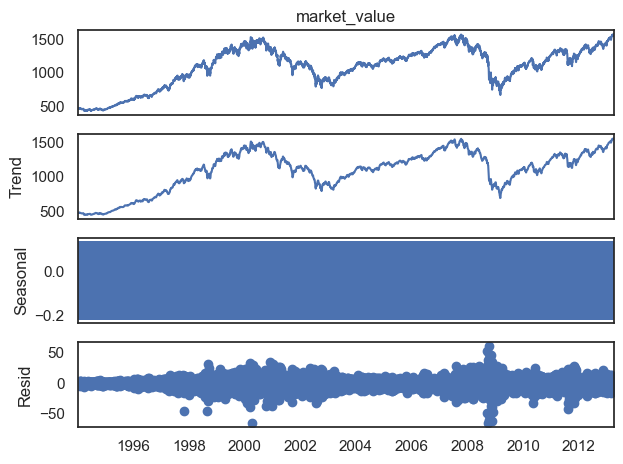

In [23]:
s_dec = seasonal_decompose(df["market_value"], model="additive")
s_dec.plot()
plt.show()

- Trend
  - The trend closely resembles the observed series, as the decomposition function uses the previous period values as the trendsetter.
  - We have already determined that the current period's prices are the best predictor for the next period's prices. If seasonal patterns are observed, we will have other prices as better predictors, e.g. if prices are consistently higher at the beginning of the month compared to the end, it would be better to use values from around 30 periods ago than 1 period ago.
- Seasonal
  - This appears as a rectangle as the values are constantly oscillating between -0.2 and 0.1, and the figure size is too small. Therefore, there is no concrete cyclical pattern evident using naiive decomposition.
  - Residual
    - The residuals vary greatly around 2000 and 2008, which can be explained by the instability caused by the dotcom and the housing prices bubbles respectively.

Overall, the results of the additive decomposition suggest no seasonality in the data.

#### Multiplicative Decomposition

The results are very similar, which provides further proof that there is no seasonality within S&P500 prices.

### ACF

- `statsmodels.graphics.tsaplots.plot_acf()` is used.
- In time series analysis, it is conventional to analyse the first 40 lags.
- zero is set to False to exclude the current period, as its correlation with itself is 1, and makes the graph more difficult comprehend correctly.

#### S&P500

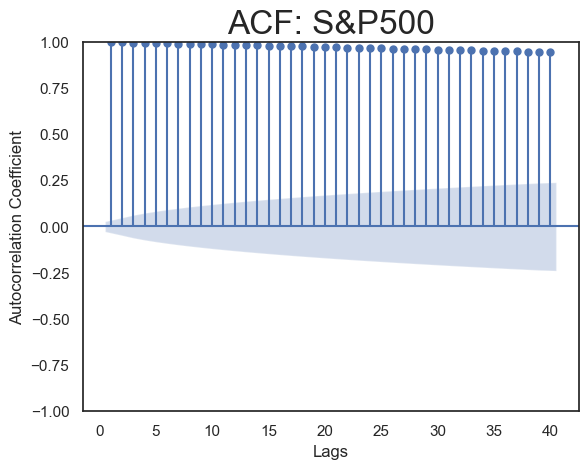

In [52]:
sgt.plot_acf(df["market_value"], lags=40, zero=False)
plt.title("ACF: S&P500", size=24)
plt.xlabel("Lags")
plt.ylabel("Autocorrelation Coefficient")
plt.show()

- The autocorrelation values are outside the blue curve which indicates 95% significance. These are significantly different from 0, which suggests the existence of autocorrelation for that specific lag.
- The level of significance area expands as the lags increase, indicating that the greater the time difference, the less likely is the autocorrelation to persist. e.g. today’s prices are more likely to be similar to yesterday’s prices than prices a month ago.
- Therefore, the autocorrelation for higher lags should be significantly different from 0.
- Since all the lines are significant, it indicates time dependence in the data.
- The autocorrelation barely decreases upto 40 lags, which suggests that prices even a month back can serve as decent estimators. (**NB** It does change when plotted over a larger range of values)

#### White Noise

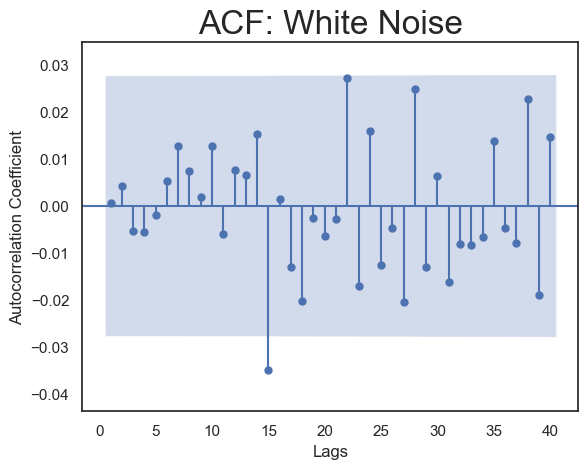

In [ ]:
sgt.plot_acf(df["white_noise"], lags=40, zero=False, auto_ylims=True)
plt.title("ACF: White Noise", size=24)
plt.xlabel("Lags")
plt.ylabel("Autocorrelation Coefficient")
plt.show()

- The autocorrelation coefficients are both positive and negative.
- Most values fall within the confidence intervals and do not reach significance. This suggests that there is no autocorrelation for any lag.

#### Random Walk

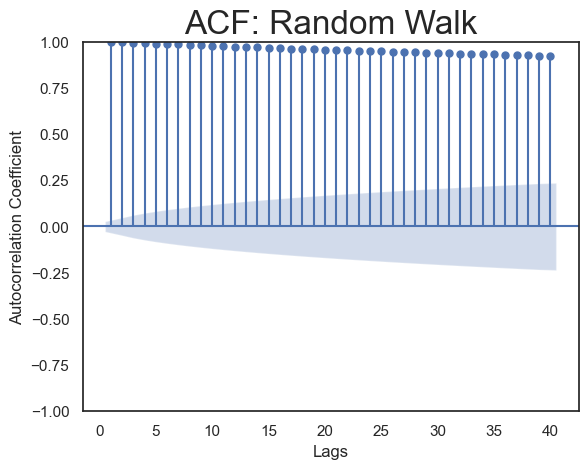

In [ ]:
sgt.plot_acf(df["random_walk"], lags=40, zero=False, auto_ylims=False)
plt.title("ACF: Random Walk", size=24)
plt.xlabel("Lags")
plt.ylabel("Autocorrelation Coefficient")
plt.show()

- This shows a pattern similar to the S&P500 price data.

### PACF

#### S&P500

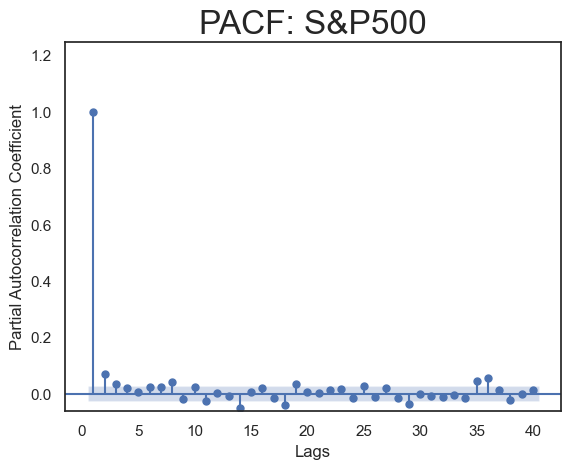

In [59]:
sgt.plot_pacf(df["market_value"], lags=40, zero=False, method="ols", auto_ylims=True)
plt.title("PACF: S&P500", size=24)
plt.xlabel("Lags")
plt.ylabel("Partial Autocorrelation Coefficient")
plt.show()

- Only the first few elements, and a few intermittent elements, are significantly different from 0.
- Some values, e.g. the 9th lag are negative, meaning higher values 9 days ago resulted in lower values today.
- The value for lag 1 is the same for ACF and PACF. This is because there are no other channels affecting this lag.
- Most values after this do not reach significance. Because they are essentially 0 and not significant, being positive or negative is somewhat random without lasting effects.

#### White Noise

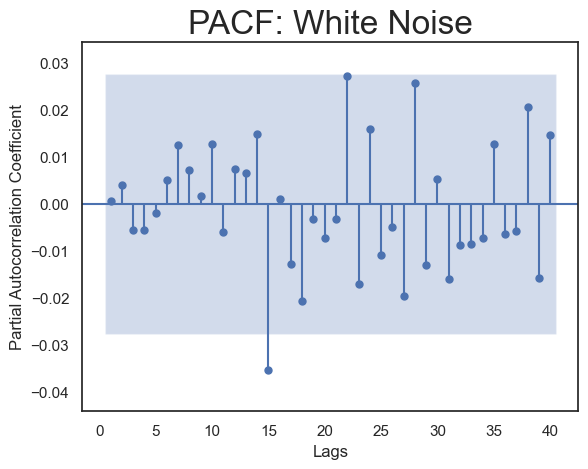

In [63]:
sgt.plot_pacf(df["white_noise"], lags=40, zero=False, method="ols", auto_ylims=True)
plt.title("PACF: White Noise", size=24)
plt.xlabel("Lags")
plt.ylabel("Partial Autocorrelation Coefficient")
plt.show()

- Most of the coefficients do not reach significance.
- This fits with there being no autocorrelation within white noise.

#### Random Walk

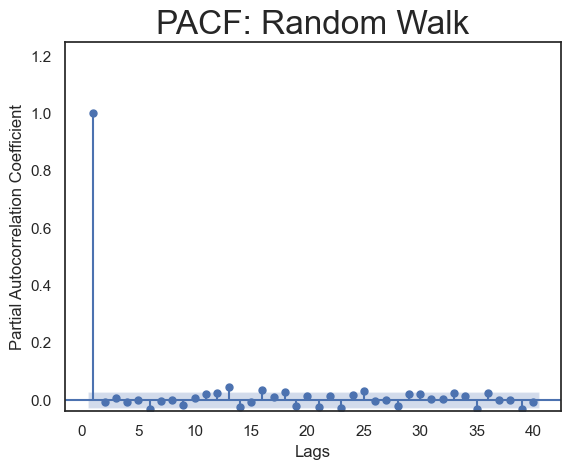

In [61]:
sgt.plot_pacf(df["random_walk"], lags=40, zero=False, method="ols", auto_ylims=True)
plt.title("PACF: Random Walk", size=24)
plt.xlabel("Lags")
plt.ylabel("Partial Autocorrelation Coefficient")
plt.show()

- The pattern is similar to that of S&P500.